In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
register_matplotlib_converters()
from time import time

In [97]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [98]:
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [99]:
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [100]:
start_date = datetime(2000,1,1)
end_date = datetime(2004,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

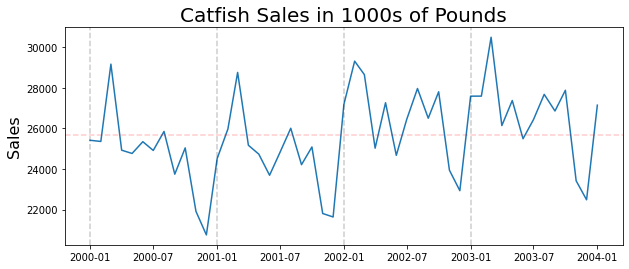

In [101]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(lim_catfish_sales.mean(), color='r', alpha=0.2, linestyle='--')

In [102]:
test_result=adfuller(lim_catfish_sales)

In [103]:
test_result

(-0.45812915913513547,
 0.8999315929015697,
 11,
 37,
 {'1%': -3.6209175221605827,
  '5%': -2.9435394610388332,
  '10%': -2.6104002410518627},
 647.1908383973351)

In [104]:
#null hypothesis : It is stationary
#alternative hypothesis : It is stationatry
def adfuller_test(sales):
    result= adfuller(sales)
    labels = ["ADF Test Statistics","p-value","#Lags Used","Number of Observations Used"]
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
        if result[1] <= 0.05:
            print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
        else:
            print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")



In [105]:
adfuller_test(lim_catfish_sales)

ADF Test Statistics : -0.45812915913513547
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
p-value : 0.8999315929015697
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
#Lags Used : 11
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
Number of Observations Used : 37
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [125]:
first_diff = lim_catfish_sales.diff(12)[12:]
first_diff.head()

Date
2001-01-01   -905.0
2001-02-01    614.0
2001-03-01   -409.0
2001-04-01    243.0
2001-05-01    -35.0
Freq: MS, Name: Total, dtype: float64

In [122]:
seasonal_differencing=(lim_catfish_sales-lim_catfish_sales.shift(12)).dropna()
seasonal_differencing.head()

Date
2001-01-01   -905.0
2001-02-01    614.0
2001-03-01   -409.0
2001-04-01    243.0
2001-05-01    -35.0
Freq: MS, Name: Total, dtype: float64

In [123]:
adfuller_test(first_diff)

ADF Test Statistics : -5.687449863458868
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
p-value : 8.216833523380969e-07
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
#Lags Used : 10
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
Number of Observations Used : 26
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


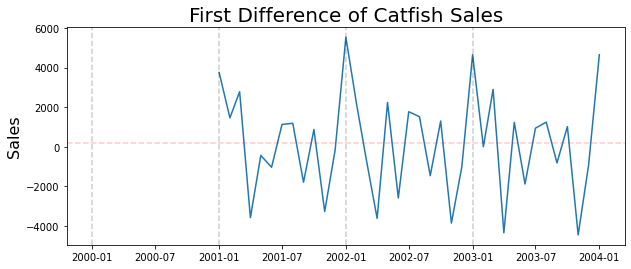

In [124]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(first_diff.mean(), color='r', alpha=0.2, linestyle='--')

In [126]:
train_end = datetime(2003,7,1)
test_end = datetime(2004,1,1)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

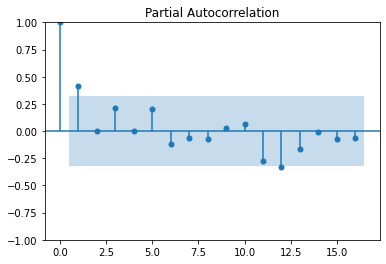

In [131]:
pacf_plot = plot_pacf(first_diff, method='ywm')

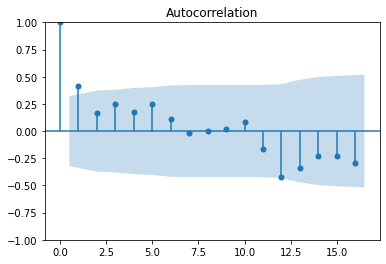

In [135]:
pacf_plot = plot_acf(first_diff)

In [146]:
model=sm.tsa.statespace.SARIMAX(first_diff,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [147]:
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.7266945838928223


C:\Users\nafissaad\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [148]:
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                   37
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -207.595
Date:                            Tue, 30 Nov 2021   AIC                            425.189
Time:                                    22:19:31   BIC                            431.079
Sample:                                01-01-2001   HQIC                           426.752
                                     - 01-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0034      0.659      0.005      0.996      -1.287       1.294
ma.L1         -0.6746      0.533   

In [149]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [150]:
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

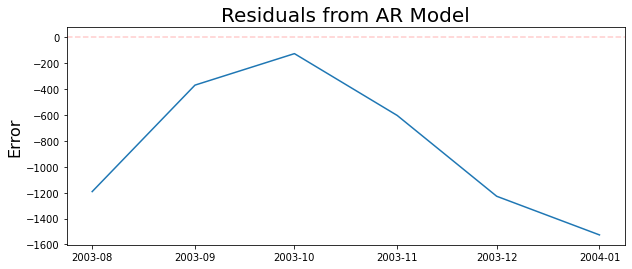

In [151]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

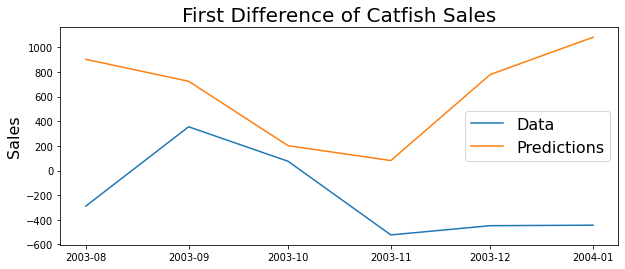

In [152]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Catfish Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)